In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib notebook
plt.rcParams['figure.figsize'] = [4,4]
plt.rcParams['figure.dpi'] = 200
# %config InlineBackend.figure_format ='retina'

%load_ext autoreload
%autoreload 2

dev = 'cpu'
from runner import get_data

In [2]:
loc = 'results'

In [3]:
r = []
for f in glob.glob(os.path.join(loc, 'models', '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    d = th.load(f)
#     print(f, len(d))
    for i in range(len(d)):
        t = {}
        t.update(k)
        t.update({'t': i})
        t.update(d[i])
        r.append(t)

In [4]:
d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

Index(['seed', 'widen', 'numc', 'noise_label', 'relabel', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 500


In [30]:
# th.save(d,'d.p')
# d = th.load(os.path.join(loc,'d.p'))
# d22 = th.load('d_2_2.p')

### Embed the models into a feature space

In [5]:
loc = 'inpca_results'

In [6]:
def get_idx(dd, cond):
    return dd.query(cond).index.tolist()

def embed(dd, fn='', ss=1, ne=3, key='yh', force=False):
    dc = dd[['seed', 'widen', 'numc', 'relabel', 't', 'err', 'verr', 'favg', 'vfavg']]
    th.save(dc, os.path.join(loc,'didx_%s.p'%fn))
    x = np.array([dd.iloc[i][key][::ss].float().numpy() for i in range(len(dd))])
    n = x.shape[0]

    if (not os.path.isfile(os.path.join(loc,'w_%s.p'%fn))) or force:
        a = np.sqrt(np.exp(x))
        a = np.moveaxis(a, 0, 1)
        w = np.zeros((n,n))
        nc = 100 if n < 4000 else 200
        print('chunks: ', nc)
        for aa in tqdm.tqdm(np.split(a, nc)):
            w += np.log(np.einsum('kil,kjl->kij', aa, aa, optimize=True)).sum(0)
        w = -w

        del a
        l = np.eye(w.shape[0]) - 1.0/w.shape[0]
        w = l @ w @ l
        print('Saving w')
        th.save(w, os.path.join(loc,'w_%s.p'%fn))
    else:
        print('Found: ', os.path.join(loc,'w_%s.p'%fn))

    w = th.load(os.path.join(loc,'w_%s.p'%fn))
    print('Projecting')
    e1,v1 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[n-(ne+1),n-1])
    e2,v2 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[0,(ne+1)])
    e = np.concatenate((e1,e2))
    v = np.concatenate((v1,v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e,v = e[ii], v[:,ii]
    xp = v*np.sqrt(np.abs(e))
    r = dict(xp=xp,w=w,e=e,v=v)
    th.save(r, os.path.join(loc,'r_%s.p'%fn))
    return

In [7]:
r = embed(d, fn='full', ss=2, key='yh')

Found:  inpca_results/w_full.p
Projecting


In [8]:
# r22 = embed(d22, ss=10)
widen = 4
numc = 4
for r in [0.0, 0.1, 0.2, 0.5, 0.9]:
    dd = d[(d['widen']==widen) & (d['numc']==numc) & (d['relabel']==r)]
    fn = 'v_widen_%d_numc_%d_r_%.1f'%(widen, numc, r)
    print('widen %d, numc %d_r_%.1f'%(widen, numc, r))
    r = embed(dd, fn=fn, ss=2, key= 'yvh', force=True)

widen 4, numc 4_r_0.0
chunks:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.00it/s]


Saving w
Projecting
widen 4, numc 4_r_0.1
chunks:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.05it/s]


Saving w
Projecting
widen 4, numc 4_r_0.2
chunks:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.19it/s]


Saving w
Projecting
widen 4, numc 4_r_0.5
chunks:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 147.46it/s]


Saving w
Projecting
widen 4, numc 4_r_0.9
chunks:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 147.83it/s]

Saving w
Projecting


In [9]:
# widen,numc=4,8
# fn = 'widen_%d_numc_%d'%(widen,numc)
loc ='inpca_results'
fn = 'full'

r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

get_idx = lambda c: dc.query(c).index.tolist()

<IPython.core.display.Javascript object>


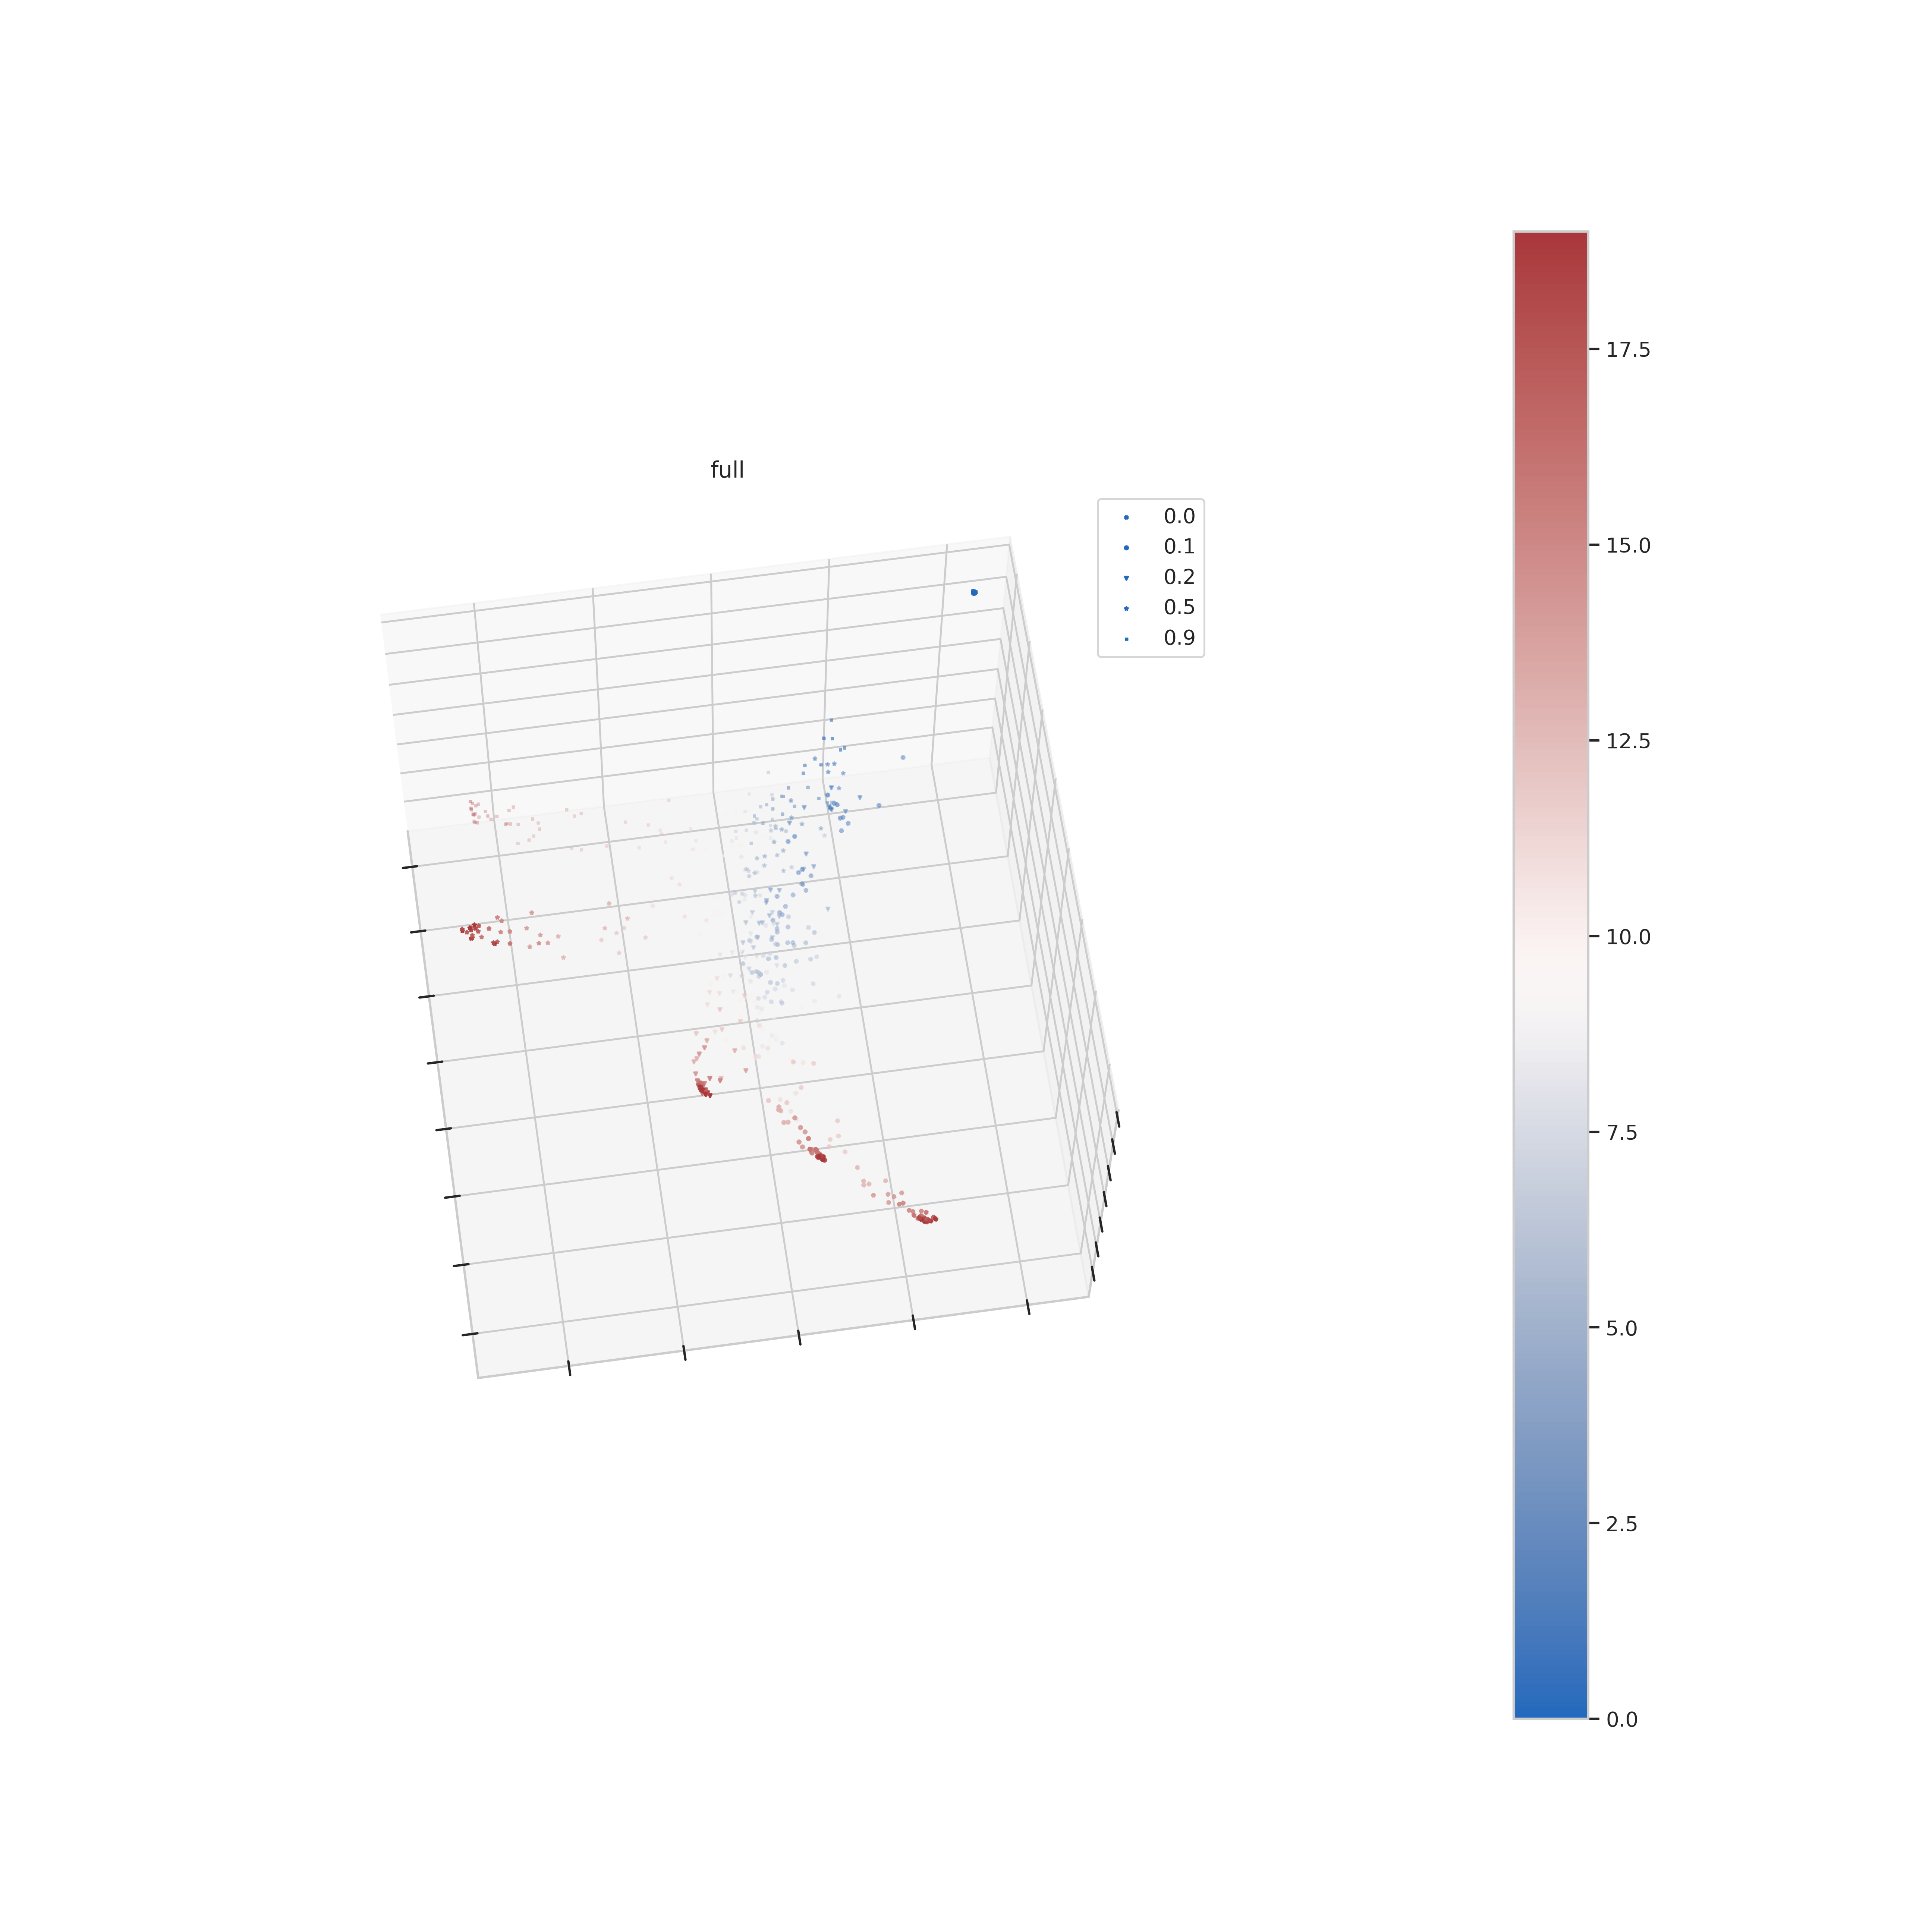

[-846543.92574384 -208325.66266141 -118697.44245571  -96896.03091008
  -84118.72612591   15084.64652976    2268.6486364     1495.19713437
    1160.548204  ]
[-846543.92574384 -208325.66266141 -118697.44245571  -96896.03091008
  -84118.72612591   15084.64652976    2268.6486364     1495.19713437
    1160.548204  ]
[-846543.92574384 -208325.66266141 -118697.44245571  -96896.03091008
  -84118.72612591   15084.64652976    2268.6486364     1495.19713437
    1160.548204  ]
[-846543.92574384 -208325.66266141 -118697.44245571  -96896.03091008
  -84118.72612591   15084.64652976    2268.6486364     1495.19713437
    1160.548204  ]
[-846543.92574384 -208325.66266141 -118697.44245571  -96896.03091008
  -84118.72612591   15084.64652976    2268.6486364     1495.19713437
    1160.548204  ]


In [10]:
fig = plt.figure(1, figsize=(8,8))
plt.clf();
ax = fig.add_subplot(projection='3d')
markers = ['x', 'o', 'v', '*', '+']
for (i, frac) in enumerate([0.0, 0.1, 0.2, 0.5, 0.9]):
    ii = get_idx(f't >= 0 & widen == 4 & numc == 4 & relabel=={frac}')
    xx = r['xp'][ii]
    ee = r['e']
    print(ee)
    c = dc['t'][ii]    
    sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                    c=c, s=3, cmap='vlag', marker=markers[i], label=frac)
    # ax.set_xlabel('pc0'); ax.set_ylabel('pc1'); ax.set_zlabel('pc2');
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
plt.colorbar(sc, pad=0.2);
plt.title(fn);
ax.legend()

In [11]:
plt.savefig('manifold_2.pdf', bbox_inches='tight')

In [ ]:
plt.figure(2); plt.clf(); plt.plot(np.abs(ee)); plt.yscale('log');

In [ ]:
ee_skl = np.array([-164083.41656593,   -5567.04529202,   -5188.73140228,
         -3968.06433274,   -3330.35466684,    2211.74081369,
           539.23097939,     462.12525554,     437.12668961])

In [ ]:
ee_bhat = ee

In [ ]:
plt.figure(2); plt.clf(); plt.plot(np.abs(ee), label='bhat'); plt.plot(np.abs(ee_skl), label='skl'); plt.yscale('log'); plt.legend()

### Noisy labels

In [ ]:
# loc = 'inpca_results_noise_wrong'
loc = 'results'

In [ ]:
r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    if f.find('{') > 0:
        k = json.loads(f[f.find('{'):-2])
        d = th.load(f)
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

In [ ]:
r = embed(d, fn='noise_full', ss=2, key='yh', force=True)

In [2]:
loc = 'results'
fn = 'full_noise'

r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

get_idx = lambda c: dc.query(c).index.tolist()

<IPython.core.display.Javascript object>


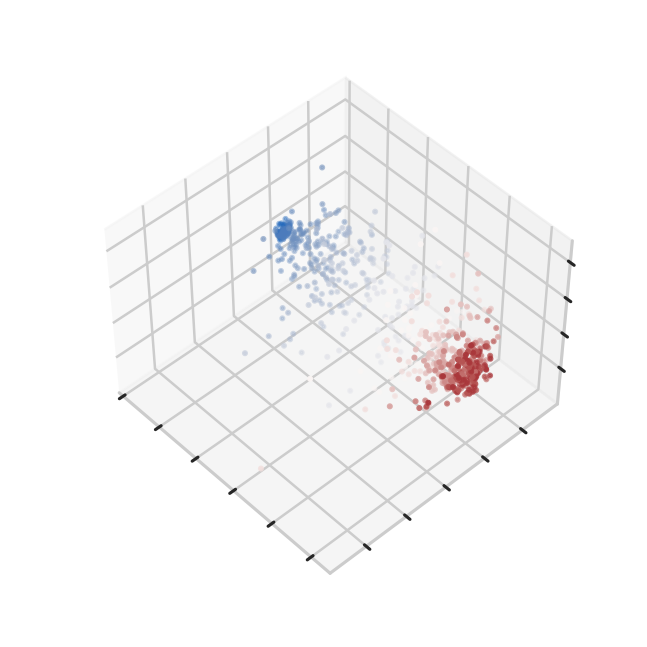

In [3]:
ii = get_idx('t >= 0 & widen == 4 and numc == 4')
xx = r['xp'][ii]
ee = r['e']
# print(ee[:3])
c = dc['t'][ii]

fig = plt.figure(3)
plt.clf();
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                c=c, s=2, cmap='vlag')
# ax.set_xlabel('pc0'); ax.set_ylabel('pc1'); ax.set_zlabel('pc2');
# plt.colorbar(sc, pad=0.2);
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
# plt.title(loc);

In [4]:
plt.savefig('manifold_noisy.pdf', bbox_inches='tight')

In [ ]:
plt.figure(4); plt.clf(); plt.plot(np.abs(ee)); plt.yscale('log');